In [1]:
import copy
import json
import numpy as np
import matplotlib.pyplot as plt

from utils import ConfigObject
from utils import reserve_pop
from utils import id_generator
from utils import writer
from utils import LibriSpeechGenerator

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F

from parts import VSConvBlock
from parts import DownSamplingBlock
from parts import UpSamplingBlock
from parts import OutBlock

## Parameters

In [2]:
jsonConfig = {
    "test_platform": False,
    "ds_prop": 0.25,
    "sr": 16000,
    "n_samples": 65536,
    
    "n_channels": 1,
    "n_classes": 1,
    "depth": 5,
    "fsize": 24,
    "moffset": 8,
    
    "batch_size": 48,
    "epochs": 25,
    "shuffle": True,
    "num_workers": 8,
    "verbose": 100,

    "checkpoint_path": "../models/model_checkpoint.pt",
    "model_path": "../models/last_model.pt",

    "save_last_batch": True,
    "writer_path": "../logs/",
    "history_path": "../logs/history.json"
}

config = ConfigObject(**jsonConfig)

In [3]:
# Data Loaders
_params = {
    'batch_size': config.batch_size,
    'shuffle': config.shuffle,
    'num_workers': config.num_workers
}

## Import Data

In [4]:
X_train = torch.load("../data/processed/noisy/train/x_train.pt")
y_train = torch.load("../data/processed/noisy/train/y_train.pt")
X_val = torch.load("../data/processed/noisy/val/x_val.pt")
y_val = torch.load("../data/processed/noisy/val/y_val.pt")

## Data Generators

In [5]:
# Data Generators
lsg = LibriSpeechGenerator(config, X_train, y_train)
lsg_val = LibriSpeechGenerator(config, X_val, y_val)

ls_generator = data.DataLoader(lsg, **_params)
ls_val_generator = data.DataLoader(lsg_val, **_params)

## Model

In [6]:
class SEWUNet(nn.Module):
    def __init__(self, config, fd=15, fu=5):
        """Speech Enhancenment using Wave-U-Net"""
        super(SEWUNet, self).__init__()

        # Hyperparameters
        self.n_channels = config.n_channels
        self.n_classes = config.n_classes
        self.depth = config.depth
        self.fsize = config.fsize
        self.moffset = config.moffset
        self.fd = fd
        self.fu = fu

        # Generate the list of in, out channels for the encoder
        self.enc_filters = [self.n_channels]
        self.enc_filters += [self.fsize * i + self.moffset
                             for i in range(1, self.depth + 1)]
        self.n_encoder = zip(self.enc_filters, self.enc_filters[1:])

        # Bottleneck block sizes
        mid_in = self.fsize * self.depth + self.moffset
        mid_out = self.fsize * (self.depth + 1) + self.moffset

        # Generate the list of in, out channels for the decoder
        self.out_dec = reserve_pop(self.enc_filters)
        self.in_dec = [mid_out + self.enc_filters[-1]]
        self.in_dec += [self.out_dec[i] + self.out_dec[i + 1]
                        for i in range(self.depth - 1)]
        self.n_decoder = zip(self.in_dec, self.out_dec)

        # Architecture and parameters
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        # Build the encoder part of the U-net architecture
        for i, (in_ch, out_ch) in enumerate(self.n_encoder):
            self.encoder.append(DownSamplingBlock(
                in_ch=in_ch,
                out_ch=out_ch,
                kernel_size=self.fd,
                padding=self.fd // 2,
                activation=nn.LeakyReLU(0.1))
            )

        # Bottleneck block for the U-net
        self.mid_block = VSConvBlock(
            in_ch=mid_in,
            out_ch=mid_out,
            kernel_size=self.fd,
            padding=self.fd // 2,
            activation=nn.LeakyReLU(0.1))

        # Build the decoder part of the U-net architecture
        for in_ch, out_ch in self.n_decoder:
            self.decoder.append(UpSamplingBlock(
                in_ch=in_ch,
                out_ch=out_ch,
                kernel_size=self.fu,
                padding=self.fu // 2,
                activation=nn.LeakyReLU(0.1),
                mode="deconv")
            )

        # Output block
        out_ch = self.out_dec[-1] + 1
        self.out_block = OutBlock(
            in_ch=out_ch,
            out_ch=self.n_classes,
            activation=nn.Tanh()
        )

    def forward(self, x):
        """"""
        enc = []
        net_in = copy.copy(x)

        for i in range(self.depth):
            x, xi = self.encoder[i](x)
            enc.append(xi)

        x = self.mid_block(x)

        for i in range(self.depth):
            x = self.decoder[i](x, enc.pop())

        x = self.out_block(x, net_in)

        return x

## Trainer

In [7]:
model = SEWUNet(config)

In [8]:
# Training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
history = {'loss': [], 'SNR': [], 'val_loss': [], 'val_SNR': []}

In [9]:
def CustomMetric():
    """Calculate the SNR of X and Y"""
    def SNR(X, Y):
        n = X.shape[2]
        return torch.mean(10 * torch.log10(
            (torch.norm(Y, dim=2)**2 / n) /
            (torch.norm(X - Y, dim=2)**2 / n)
        ))
    return SNR

In [10]:
# Build optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-6,
    betas=(0.9, 0.999))

# lr_scheduler = torch.optim.lr_scheduler(optimizer)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# Loss and metric
m_loss = nn.L1Loss()
m_snr = CustomMetric()

# Print validation metric before trainer
print("SNR (Validation): {}".format(m_snr(lsg_val.X, lsg_val.y).item()))

SNR (Validation): 10.054699897766113


In [11]:
# Copy model to device
model = model.to(device)

In [12]:
# Calculate the number of trainable parameters in the model
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
sum([np.prod(p.size()) for p in model_parameters])

1259572

In [13]:
# Function to display trainning metrics
def _display_metrics(epoch, it, steps, loss, metric):
    print("Epoch [{:02d}/{:02d}]".format(
        epoch + 1, config.epochs), end=", ")

    print("Step [{:03d}/{:03d}]".format(
        it + 1, steps), end=", ")

    print("Loss: {}, SNR: {}".format(
        loss, metric))

In [14]:
# Train the model over epochs
steps = len(ls_generator)

for epoch in range(config.epochs):
    # training and val metrics for all data
    loss, metric = 0.0, 0.0
    val_loss, val_metric = 0.0, 0.0

    # ======================== Training ============================= #
    for i, (local_batch, local_labels) in enumerate(ls_generator):
        # Transfer to Device
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)

        # Set gradient
        optimizer.zero_grad()

        # Forward pass, backward pass, optimize
        outputs = model(local_batch)
        loss_batch = m_loss(outputs, local_labels)
        batch_metric = m_snr(outputs, local_labels)
        loss_batch.backward()
        optimizer.step()

        # Compute metrics to all batch
        loss += loss_batch.item() * len(local_batch)
        metric += batch_metric.item() * len(local_batch)

        # Print the loss every "verbose" batches
        if (i + 1) % config.verbose == 0:
            _display_metrics(epoch, i, steps,
                loss_batch.item(), batch_metric.item())

    # Compute the statistics of the last epoch and save to history
    history['loss'].append(loss / len(lsg))
    history['SNR'].append(metric / len(lsg))

    # Checkpoint the model
    torch.save(model.state_dict(), config.checkpoint_path)
    
    # Print Validation statistics
    print(".:. Training metrics =", end=" ")
    print("Loss: {}, SNR: {}".format(loss / len(lsg), metric / len(lsg)))
    
    # ======================= Validation ============================ #
    with torch.no_grad():
        for local_batch, local_labels in ls_val_generator:
            # Transfer to device
            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)

            # Predict, get loss and metric
            outputs = model(local_batch)
            val_loss += m_loss(outputs, local_labels).item() \
                * len(local_batch)

            val_metric += m_snr(outputs, local_labels).item() \
                * len(local_batch)

        val_loss /= len(lsg_val)
        val_metric /= len(lsg_val)
                
    # Print Validation statistics
    print(".:. Validation metrics =", end=" ")
    print("Loss: {}, SNR: {}".format(val_loss, val_metric))

    # Compute the metrics and loss of last batch and save to history
    history['val_loss'].append(val_loss)
    history['val_SNR'].append(val_metric)
    lr_scheduler.step(val_loss)

Epoch [01/25], Step [100/601], Loss: 0.04481250047683716, SNR: -2.5450737476348877
Epoch [01/25], Step [200/601], Loss: 0.02877095341682434, SNR: 2.213153600692749
Epoch [01/25], Step [300/601], Loss: 0.023987770080566406, SNR: 4.370020866394043
Epoch [01/25], Step [400/601], Loss: 0.020671632140874863, SNR: 5.537546157836914
Epoch [01/25], Step [500/601], Loss: 0.019160522148013115, SNR: 5.276719570159912
Epoch [01/25], Step [600/601], Loss: 0.016265468671917915, SNR: 6.5602827072143555
.:. Training metrics = Loss: 0.030240787454178093, SNR: 2.6722534397204463
.:. Validation metrics = Loss: 0.01624396652883794, SNR: 6.741339147421961
Epoch [02/25], Step [100/601], Loss: 0.016142312437295914, SNR: 6.637270927429199
Epoch [02/25], Step [200/601], Loss: 0.019648820161819458, SNR: 7.307307720184326
Epoch [02/25], Step [300/601], Loss: 0.015165120363235474, SNR: 8.359166145324707
Epoch [02/25], Step [400/601], Loss: 0.015007528476417065, SNR: 8.814380645751953
Epoch [02/25], Step [500/601]

.:. Training metrics = Loss: 0.009399542909277926, SNR: 12.672569466073716
.:. Validation metrics = Loss: 0.008638795317687376, SNR: 12.990625762586333
Epoch [14/25], Step [100/601], Loss: 0.008114869706332684, SNR: 12.469038963317871
Epoch [14/25], Step [200/601], Loss: 0.008679146878421307, SNR: 12.911623001098633
Epoch [14/25], Step [300/601], Loss: 0.009862237609922886, SNR: 13.132974624633789
Epoch [14/25], Step [400/601], Loss: 0.009603460319340229, SNR: 12.313213348388672
Epoch [14/25], Step [500/601], Loss: 0.009982134215533733, SNR: 12.851435661315918
Epoch [14/25], Step [600/601], Loss: 0.008565930649638176, SNR: 12.81100082397461
.:. Training metrics = Loss: 0.009263302745082668, SNR: 12.795548814920187
.:. Validation metrics = Loss: 0.008570076439714887, SNR: 13.165480740074758
Epoch [15/25], Step [100/601], Loss: 0.00883228238672018, SNR: 13.8794584274292
Epoch [15/25], Step [200/601], Loss: 0.00840803049504757, SNR: 13.243895530700684
Epoch [15/25], Step [300/601], Loss: 

In [15]:
# Save the last model
torch.save(model.state_dict(), config.model_path)

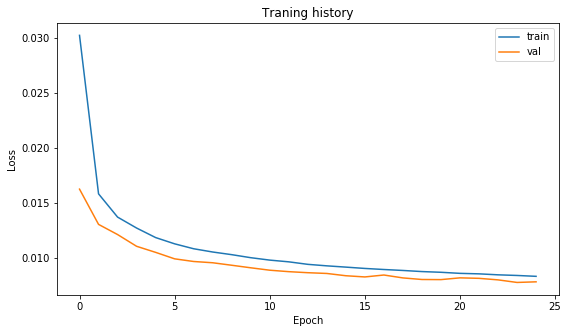

In [16]:
# Plot network history
plt.figure(figsize=(9,5))
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Traning history')
plt.legend()
plt.show()

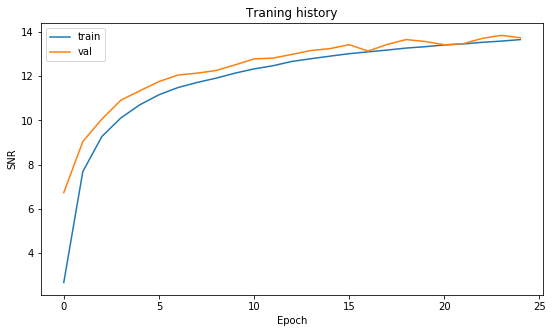

In [17]:
# Plot network history
plt.figure(figsize=(9,5))
plt.plot(history['SNR'], label='train')
plt.plot(history['val_SNR'], label='val')
plt.ylabel('SNR')
plt.xlabel('Epoch')
plt.title('Traning history')
plt.legend()
plt.show()

In [18]:
# Save history to a JSON file
with open(config.history_path, 'w') as fp:
    json.dump(history, fp)

## Test

In [19]:
X_test = torch.load("../data/processed/noisy/test/x_test.pt")
y_test = torch.load("../data/processed/noisy/test/y_test.pt")

In [20]:
lsg_test = LibriSpeechGenerator(config, X_test, y_test)
ls_test_generator = data.DataLoader(lsg_test, **_params)

In [21]:
X_test.shape

torch.Size([3874, 1, 65536])

In [22]:
# Print validation metric before trainer
print("SNR (Test): {}".format(m_snr(lsg_test.X, lsg_test.y).item()))

SNR (Test): 10.054566383361816


In [23]:
test_loss, test_metric = 0.0, 0.0
with torch.no_grad():
    for local_batch, local_labels in ls_test_generator:
        # Transfer to device
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)

        # Predict, get loss and metric
        outputs = model(local_batch)
        test_loss += m_loss(outputs, local_labels).item() \
            * len(local_batch)

        test_metric += m_snr(outputs, local_labels).item() \
            * len(local_batch)
        
        writer(local_batch, local_labels,
               outputs, config.sr, config.writer_path)

    test_loss /= len(lsg_test)
    test_metric /= len(lsg_test)

In [24]:
import os

test_history = {
    'SNR_ini': m_snr(lsg_test.X, lsg_test.y).item(),
    'SNR': val_metric, 
    'loss': val_loss
}

with open(os.path.join(config.writer_path, 'test_history.json') , 'w') as fp:
    json.dump(test_history, fp)